# LightGBM(GPU) Install

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

Cloning into 'LightGBM'...
remote: Enumerating objects: 26297, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 26297 (delta 40), reused 56 (delta 21), pack-reused 26200
Receiving objects: 100% (26297/26297), 19.10 MiB | 27.85 MiB/s, done.
Resolving deltas: 100% (19422/19422), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/python-package/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.  

# Install package

In [ ]:
import os
# python global seed
os.environ['PYTHONHASHSEED'] = str(42)
# tensorflow seed (not working for GPU)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
# weight and bias
os.environ["WANDB_API_KEY"] = "b838b62906ab267778c6e05b913ba6c4a27699b2"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# # TextVectorization layer in tf 2.6 don't support "sparse=True" option which is used on TF-IDF
# # !pip install -q tensorflow==2.6.0
!pip install -q tensorflow==2.8
!pip install -q tensorflow-recommenders==0.6
# !pip install -q scann==1.2.3
# !pip install -q scann==1.2.6
# # !pip install -q tensorflow-datasets
!pip install -q tensorflow-addons
# !pip install -q tensorflow-hub
# # !pip install -q keras-tuner

# !pip install -q transformers

!pip install -q statsmodels
!pip install -q xgboost
# !pip install -q lightgbm
!pip install -q catboost
!pip install -q missingpy

!pip install -q optuna
!pip install -q wandb

Mounted at /content/drive
     / 668.3 MB 414 kB/s
     |████████████████████████████████| 462 kB 8.1 MB/s 
     |████████████████████████████████| 85 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 9.0 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 3.3 MB/s 
     |████████████████████████████████| 308 kB 6.8 MB/s 
     |████████████████████████████████| 81 kB 10.6 MB/s 
     |████████████████████████████████| 209 kB 88.2 MB/s 
     |████████████████████████████████| 78 kB 8.2 MB/s 
     |████████████████████████████████| 146 kB 76.2 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 112 kB 63.1 MB/s 
     |████████████████████████████████| 1.8 MB 7.7 MB/s 
     |████████████████████████████████| 181 kB 64.9 MB/s 
     |████████████████████████████████| 145 kB 67.0 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 


# Import

In [ ]:
def config_missingpy():
    try:
        with open("/usr/local/lib/python3.7/site-packages/missingpy/knnimpute.py", 'r') as file:
        # read a list of lines into data
            data = file.readlines()
            # now change the 2nd line, note that you have to add a newline
            data[12] = 'from sklearn.neighbors._base import _check_weights\n'
            data[13] = 'from sklearn.neighbors._base import _get_weights\n'
        # and write everything back
        with open("/usr/local/lib/python3.7/site-packages/missingpy/knnimpute.py", 'w') as file:
            file.writelines(data)
    except:
        print("path error : /usr/local/lib/python3.7/site-packages/missingpy/knnimpute.py")
    try:
        with open("/usr/local/lib/python3.7/dist-packages/missingpy/knnimpute.py", 'r') as file:
        # read a list of lines into data
            data = file.readlines()
            # now change the 2nd line, note that you have to add a newline
            data[12] = 'from sklearn.neighbors._base import _check_weights\n'
            data[13] = 'from sklearn.neighbors._base import _get_weights\n'
        # and write everything back
        with open("/usr/local/lib/python3.7/dist-packages/missingpy/knnimpute.py", 'w') as file:
            file.writelines(data)
    except:
        print("path error : /usr/local/lib/python3.7/site-packages/missingpy/knnimpute.py")

In [ ]:
import os
import sys
import shutil
from glob import glob
import multiprocessing as mp
import gc
from pathlib import Path
from scipy import stats
from scipy.special import boxcox, softmax
from scipy import sparse
import itertools

from multiprocessing import cpu_count
import copy
import pickle
import warnings
from datetime import datetime, timedelta
from time import time, sleep, mktime
from matplotlib import font_manager as fm, rc, rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import random as rnd
import psutil
import optuna
from optuna import Trial, create_study
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
import wandb

import numpy as np
from numpy import array, nan, random as np_rnd, where
from numpy import dot
from numpy.linalg import norm
import pandas as pd
from pandas import DataFrame as dataframe, Series as series, isna, read_csv
from pandas.tseries.offsets import DateOffset

from sklearn.model_selection import train_test_split as tts, StratifiedKFold, GroupKFold, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
from sklearn import metrics
# from sklearn.compose import ColumnTransformer
config_missingpy(); from missingpy import MissForest
# from sklearn.impute import KNNImputer
# from sklearn.feature_extraction.text import TfidfVectorizer

# try:
#     # RAPIDS config
#     os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
#     os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
#     os.environ['CONDA_PREFIX'] = '/usr/local'
#     import cudf as cd
#     import cupy as cp
#     from cuml.cluster import KMeans
#     from cuml.neighbors import NearestNeighbors
#     from cuml.metrics.cluster import silhouette_score
# except:
#     print("RAPIDS Import ERROR")

from sklearn import linear_model as lm
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# ===== tensorflow =====
import tensorflow as tf
from tensorflow import random as tf_rnd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import metrics as tf_metrics
from tensorflow.keras import callbacks as tf_callbacks
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from keras.utils.layer_utils import count_params

# import keras_tuner as kt
# from keras_tuner import HyperModel
import tensorflow_hub as tf_hub
import tensorflow_recommenders as tfrs

# # # ===== pytorch =====
# import torch
# from torch.utils.data import DataLoader
# from transformers import AutoTokenizer
# from transformers import AutoModel

import librosa

# GPU memory setting
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

warnings.filterwarnings(action='ignore')
rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 200)
# plt.rc('font', family='NanumSquareB')

path error : /usr/local/lib/python3.7/site-packages/missingpy/knnimpute.py


In [ ]:
# ===== utility functions =====
# label encoding for categorical column with excepting na value
def seed_everything(seed=42):
    # python random module
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # RAPIDS random
    try:
        cp.random.seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
    except:
        pass
def which(bool_list):
    return where(bool_list)[0]
def easyIO(x=None, path=None, op="r"):
    tmp = None
    if op == "r":
        with open(path, "rb") as f:
            tmp = pickle.load(f)
        return tmp
    elif op == "w":
        with open(path, "wb") as f:
            pickle.dump(x, f)
    else:
        print("Unknown operation type")
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]
def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]
def orderElems(for_order, using_ref):
    return [i for i in using_ref if i in for_order]
# concatenate by row
def cbr(df1, df2):
    if type(df1) == series:
        tmp_concat = series(pd.concat([dataframe(df1), dataframe(df2)], axis=0, ignore_index=True).iloc[:,0])
        tmp_concat.reset_index(drop=True, inplace=True)
    elif type(df1) == dataframe:
        tmp_concat = pd.concat([df1, df2], axis=0, ignore_index=True)
        tmp_concat.reset_index(drop=True, inplace=True)
    elif type(df1) == np.ndarray:
        tmp_concat = np.concatenate([df1, df2], axis=0)
    else:
        print("Unknown Type: return 1st argument")
        tmp_concat = df1
    return tmp_concat
def change_width(ax, new_value):
    for patch in ax.patches :
        current_width = patch.get_width()
        adj_value = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + adj_value * .5)
def week_of_month(date):
    month = date.month
    week = 0
    while date.month == month:
        week += 1
        date -= timedelta(days=7)
    return week
def getSeason(date):
    month = date.month
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
    else:
        return "Winter"
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def dispPerformance(result_dic):
    perf_table = dataframe()
    index_names = []
    for k, v in result_dic.items():
        index_names.append(k)
        perf_table = pd.concat([perf_table, series(v["performance"]).to_frame().T], ignore_index=True, axis=0)
    perf_table.index = index_names
    perf_table.sort_values(perf_table.columns[0], inplace=True)
    print(perf_table)
    return perf_table
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power)
def xgb_custom_lossfunction(alpha = 1):
    def support_under_mse(label, pred):
        # grad : 1차 미분
        # hess : 2차 미분
        residual = (label - pred).astype("float")
        grad = np.where(residual > 0, -2 * alpha * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * alpha, 2.0)
        return grad, hess
    return support_under_mse
def pd_flatten(df):
    df = df.unstack()
    df.index = [str(i) + "_" + str(j) for i, j in df.index]
    return df
def tf_losses_rmse(y_true, y_pred, sample_weight=None):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred) ** 2)) if sample_weight is None else tf.sqrt(tf.reduce_mean(((y_true - y_pred) ** 2) * sample_weight))
def tf_loss_nmae(y_true, y_pred, sample_weight=False):
    mae = tf.reduce_mean(tf.math.abs(y_true - y_pred))
    score = tf.math.divide(mae, tf.reduce_mean(tf.math.abs(y_true)))
    return score
def text_extractor(string, lang="eng", spacing=True):
    # # 괄호를 포함한 괄호 안 문자 제거 정규식
    # re.sub(r'\([^)]*\)', '', remove_text)
    # # <>를 포함한 <> 안 문자 제거 정규식
    # re.sub(r'\<[^)]*\>', '', remove_text)
    if lang == "eng":
        text_finder = re.compile('[^ A-Za-z]') if spacing else re.compile('[^A-Za-z]')
    elif lang == "kor":
        text_finder = re.compile('[^ ㄱ-ㅣ가-힣+]') if spacing else re.compile('[^ㄱ-ㅣ가-힣+]')
    # default : kor + eng
    else:
        text_finder = re.compile('[^ A-Za-zㄱ-ㅣ가-힣+]') if spacing else re.compile('[^A-Za-zㄱ-ㅣ가-힣+]')
    return text_finder.sub('', string)
def memory_usage(message='debug'):
    # current process RAM usage
    p = psutil.Process()
    rss = p.memory_info().rss / 2 ** 20 # Bytes to MB
    print(f"[{message}] memory usage: {rss: 10.3f} MB")
    return rss
def cos_sim(a, b):
  return dot(a, b)/(norm(a) * norm(b))
class MyLabelEncoder:
    def __init__(self, preset={}):
        # dic_cat format -> {"col_name": {"value": replace}}
        self.dic_cat = preset
    def fit_transform(self, data_x, col_names):
        tmp_x = copy.deepcopy(data_x)
        for i in col_names:
            # if key is not in dic, update dic
            if i not in self.dic_cat.keys():
                tmp_dic = dict.fromkeys(sorted(set(tmp_x[i]).difference([nan])))
                label_cnt = 0
                for j in tmp_dic.keys():
                    tmp_dic[j] = label_cnt
                    label_cnt += 1
                self.dic_cat[i] = tmp_dic
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x
    def transform(self, data_x):
        tmp_x = copy.deepcopy(data_x)
        for i in self.dic_cat.keys():
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x
    def clear(self):
        self.dic_cat = {}
class MyOneHotEncoder:
    def __init__(self, label_preset={}):
        self.dic_cat = {}
        self.label_preset = label_preset
    def fit_transform(self, data_x, col_names):
        tmp_x = dataframe()
        for i in data_x:
            if i not in col_names:
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                self.dic_cat[i] = OneHotEncoder(sparse=False, handle_unknown="ignore")
                conv = self.dic_cat[i].fit_transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j:
                                col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def transform(self, data_x):
        tmp_x = dataframe()
        for i in data_x:
            if not i in list(self.dic_cat.keys()):
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                conv = self.dic_cat[i].transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j: col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def clear(self):
        self.dic_cat = {}
        self.label_preset = {}
class MyKNNImputer:
    def __init__(self, k=5):
        self.imputer = KNNImputer(n_neighbors=k)
        self.dic_cat = {}
    def fit_transform(self, x, cat_vars=None):
        if cat_vars is None:
            x_imp = dataframe(self.imputer.fit_transform(x), columns=x.columns)
        else:
            naIdx = dict.fromkeys(cat_vars)
            for i in cat_vars:
                self.dic_cat[i] = diff(list(sorted(set(x[i]))), [nan])
                naIdx[i] = list(which(array(x[i].isna())))
            x_imp = dataframe(self.imputer.fit_transform(x), columns=x.columns)

            # if imputed categorical value are not in the range, adjust the value
            for i in cat_vars:
                x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
                for j in naIdx[i]:
                    if x_imp[i][j] not in self.dic_cat[i]:
                        if x_imp[i][j] < self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][0]
                        elif x_imp[i][j] > self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][len(self.dic_cat[i]) - 1]
        return x_imp
    def transform(self, x):
        if len(self.dic_cat.keys()) == 0:
            x_imp = dataframe(self.imputer.transform(x), columns=x.columns)
        else:
            naIdx = dict.fromkeys(self.dic_cat.keys())
            for i in self.dic_cat.keys():
                naIdx[i] = list(which(array(x[i].isna())))
            x_imp = dataframe(self.imputer.transform(x), columns=x.columns)

            # if imputed categorical value are not in the range, adjust the value
            for i in self.dic_cat.keys():
                x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
                for j in naIdx[i]:
                    if x_imp[i][j] not in self.dic_cat[i]:
                        if x_imp[i][j] < self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][0]
                        elif x_imp[i][j] > self.dic_cat[i][0]:
                            x_imp[i][naIdx[i]] = self.dic_cat[i][len(self.dic_cat[i]) - 1]
        return x_imp
    def clear(self):
        self.imputer = None
        self.dic_cat = {}
def remove_outlier(df, std=3, mode="remove"):
    tmp_df = df.copy()
    if mode == "remove":
        outlier_mask = (np.abs(stats.zscore(tmp_df)) > std).all(axis=1)
        print("found outlier :", outlier_mask.sum())
        tmp_df = tmp_df[~outlier_mask]
    elif mode == "interpolate":
        tmp_outlier = []
        for i in tmp_df:
            outlier_mask = (np.abs(stats.zscore(tmp_df[i])) > std)
            tmp_outlier.append(outlier_mask.sum())
            if tmp_outlier[-1] == 0:
                continue
            tmp_df[i][outlier_mask] = np.nan
            tmp_df[i] = tmp_df[i].interpolate(method='linear').bfill()
        print("found outlier :", np.sum(outlier_mask))
    return tmp_df
def convert_sparse_matrix_to_sparse_tensor(X, sorted=True):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape)) if sorted else tf.SparseTensor(indices, coo.data, coo.shape)
seed_everything()

In [ ]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/projects/Dacon/covid19_diagnostics/"

# Preprocessing

In [ ]:
df_full = pd.read_csv(folder_path + 'open.zip (Unzipped Files)/train_data.csv')
df_test = pd.read_csv(folder_path + 'open.zip (Unzipped Files)/test_data.csv')

In [ ]:
df_full.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,1,24,female,0,1,0
1,2,51,male,0,0,0
2,3,22,male,0,0,0
3,4,29,female,1,0,0
4,5,23,male,0,0,0


In [ ]:
df_test.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,3806,48,female,1,0
1,3807,24,female,0,0
2,3808,29,male,0,0
3,3809,39,female,0,0
4,3810,34,male,0,0


In [ ]:
def get_mfcc_feature(df, data_type):
    # Data Folder path
    root_folder = folder_path + 'open.zip (Unzipped Files)/'
    features = []
    for uid in tqdm(df['id']):
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_df], axis=1)
    return df
    print('Done.')

In [ ]:
def get_vggish_feature(df, data_type):
    pretrained_vggish = tf_hub.load('https://tfhub.dev/google/vggish/1')
    avg_pooling = layers.GlobalAveragePooling1D()

    # Data Folder path
    root_folder = folder_path + 'open.zip (Unzipped Files)/'
    features = []
    for uid in tqdm(df['id']):
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        # sampling rate : 16000 (16kHz)
        y, sr = librosa.load(path, sr=16000)

        # getting averaged vggish feature
        y = pretrained_vggish(y)
        features.append(avg_pooling(tf.expand_dims(y, 0)).numpy()[0])
    
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    feature_df = pd.DataFrame(features, columns=['vggish_' + str(x) for x in range(128)])
    if feature_df.isna().sum().sum() > 0:
        print("INFO : df includes na values")
    df = pd.concat([df, feature_df], axis=1)
    return df
    print('Done.')

In [ ]:
CFG = {
    'SR':16000,
    'N_MFCC':32, # MFCC 벡터를 추출할 개수
    'SEED':41
}

# df_full = get_mfcc_feature(df_full, 'train')
# df_test = get_mfcc_feature(df_test, 'test')

In [ ]:
# easyIO(df_full, folder_path + "dataset/train_mfcc.csv", "w")
# easyIO(df_test, folder_path + "dataset/test_mfcc.csv", "w")

In [ ]:
df_full = get_vggish_feature(df_full, 'train')
df_test = get_vggish_feature(df_test, 'test')

KeyboardInterrupt: ignored

In [ ]:
# easyIO(df_full, folder_path + "dataset/train_vggish.csv", "w")
# easyIO(df_test, folder_path + "dataset/test_vggish.csv", "w")

# Quick Start Session

In [ ]:
CFG = {
    'SR':16000,
    'N_MFCC':32, # MFCC 벡터를 추출할 개수
    'SEED':41
}
audio_feature_type = "mfcc"

# CFG = {
#     'SR':16000,
#     'N_MFCC':64, # MFCC 벡터를 추출할 개수
#     'SEED':41
# }
# audio_feature_type = "mfcc_64"

# audio_feature_type = "vggish"

In [ ]:
target_var = "covid19"
num_vars = ["age"]
bin_vars = ["gender", "respiratory_condition", "fever_or_muscle_pain"]
cat_vars = []

if audio_feature_type == "vggish":
    audio_vars = [audio_feature_type + "_" + str(i) for i in range(128)]
elif audio_feature_type == "mfcc" or audio_feature_type == "mfcc_64":
    audio_vars = ["mfcc_" + str(i) for i in range(1,CFG['N_MFCC']+1)]

In [ ]:
df_full = easyIO(None, folder_path + "dataset/train_" + audio_feature_type + ".csv", "r")
df_test = easyIO(None, folder_path + "dataset/test_" + audio_feature_type + ".csv", "r")

In [ ]:
df_full.drop("id", axis=1, inplace=True)
df_test.drop("id", axis=1, inplace=True)

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3805 entries, 0 to 3804
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    3805 non-null   int64  
 1   gender                 3805 non-null   object 
 2   respiratory_condition  3805 non-null   int64  
 3   fever_or_muscle_pain   3805 non-null   int64  
 4   covid19                3805 non-null   int64  
 5   mfcc_1                 3805 non-null   float32
 6   mfcc_2                 3805 non-null   float32
 7   mfcc_3                 3805 non-null   float32
 8   mfcc_4                 3805 non-null   float32
 9   mfcc_5                 3805 non-null   float32
 10  mfcc_6                 3805 non-null   float32
 11  mfcc_7                 3805 non-null   float32
 12  mfcc_8                 3805 non-null   float32
 13  mfcc_9                 3805 non-null   float32
 14  mfcc_10                3805 non-null   float32
 15  mfcc

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5732 entries, 0 to 5731
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    5732 non-null   int64  
 1   gender                 5732 non-null   object 
 2   respiratory_condition  5732 non-null   int64  
 3   fever_or_muscle_pain   5732 non-null   int64  
 4   mfcc_1                 5732 non-null   float32
 5   mfcc_2                 5732 non-null   float32
 6   mfcc_3                 5732 non-null   float32
 7   mfcc_4                 5732 non-null   float32
 8   mfcc_5                 5732 non-null   float32
 9   mfcc_6                 5732 non-null   float32
 10  mfcc_7                 5732 non-null   float32
 11  mfcc_8                 5732 non-null   float32
 12  mfcc_9                 5732 non-null   float32
 13  mfcc_10                5732 non-null   float32
 14  mfcc_11                5732 non-null   float32
 15  mfcc

# Feature Enginnering

In [ ]:
# for i in df_full:
#     print(df_full[i].value_counts(), "\n")

In [ ]:
tmp = []
for i in df_full["gender"]:
    if i == "male":
        tmp.append(1.0)
    elif i == "female":
        tmp.append(0.0)
    else:
        tmp.append(nan)
df_full["gender"] = tmp
df_full = df_full.dropna().reset_index(drop=True)

tmp = []
for i in df_test["gender"]:
    if i == "male":
        tmp.append(1.0)
    elif i == "female":
        tmp.append(0.0)
    else:
        tmp.append(0.5)
df_test["gender"] = tmp

In [ ]:
# age discretization for 8, 4 groups

df_full["age_disc_8"] = pd.cut(df_full["age"], bins=[-np.inf, 10, 20, 30, 40, 50, 60, 70, np.inf], right=False, labels=list(range(8))).astype("float32")
df_full["age_disc_4"] = pd.cut(df_full["age"], bins=[-np.inf, 20, 40, 60, np.inf], right=False, labels=list(range(4))).astype("float32")

df_test["age_disc_8"] = pd.cut(df_test["age"], bins=[-np.inf, 10, 20, 30, 40, 50, 60, 70, np.inf], right=False, labels=list(range(8))).astype("float32")
df_test["age_disc_4"] = pd.cut(df_test["age"], bins=[-np.inf, 20, 40, 60, np.inf], right=False, labels=list(range(4))).astype("float32")

df_full = pd.concat([df_full.drop("age_disc_8", axis=1), dataframe(tf.keras.utils.to_categorical(df_full["age_disc_8"], num_classes=8, dtype='float32'), columns=["age_disc8_" + str(i) for i in range(8)])], axis=1)
df_full = pd.concat([df_full.drop("age_disc_4", axis=1), dataframe(tf.keras.utils.to_categorical(df_full["age_disc_4"], num_classes=4, dtype='float32'), columns=["age_disc4_" + str(i) for i in range(4)])], axis=1)

df_test = pd.concat([df_test.drop("age_disc_8", axis=1), dataframe(tf.keras.utils.to_categorical(df_test["age_disc_8"], num_classes=8, dtype='float32'), columns=["age_disc8_" + str(i) for i in range(8)])], axis=1)
df_test = pd.concat([df_test.drop("age_disc_4", axis=1), dataframe(tf.keras.utils.to_categorical(df_test["age_disc_4"], num_classes=4, dtype='float32'), columns=["age_disc4_" + str(i) for i in range(4)])], axis=1)

In [ ]:
# covid19 symptom interaction (2:both, 1:either, 0:neither)

df_full["symptom_class"] = (df_full["respiratory_condition"] + df_full["fever_or_muscle_pain"]).astype("float32")
df_test["symptom_class"] = (df_test["respiratory_condition"] + df_test["fever_or_muscle_pain"]).astype("float32")

df_full = pd.concat([df_full.drop("symptom_class", axis=1), dataframe(tf.keras.utils.to_categorical(df_full["symptom_class"], num_classes=3, dtype='float32'), columns=["symptom_class_" + str(i) for i in range(3)])], axis=1)
df_test = pd.concat([df_test.drop("symptom_class", axis=1), dataframe(tf.keras.utils.to_categorical(df_test["symptom_class"], num_classes=3, dtype='float32'), columns=["symptom_class_" + str(i) for i in range(3)])], axis=1)

# df_full = pd.concat([df_full, dataframe(tf.keras.utils.to_categorical(df_full["symptom_class"], num_classes=3, dtype='float32'), columns=["symptom_class_" + str(i) for i in range(3)])], axis=1)
# df_test = pd.concat([df_test, dataframe(tf.keras.utils.to_categorical(df_test["symptom_class"], num_classes=3, dtype='float32'), columns=["symptom_class_" + str(i) for i in range(3)])], axis=1)

In [ ]:
# # covid19 symptom interaction (1:either, 1:none)

# df_full["symptom_class"] = (df_full["respiratory_condition"].astype("bool") | df_full["fever_or_muscle_pain"].astype("bool")).astype("float32")
# df_test["symptom_class"] = (df_test["respiratory_condition"].astype("bool") | df_test["fever_or_muscle_pain"].astype("bool")).astype("float32")

# # df_full = pd.concat([df_full.drop("symptom_class", axis=1), dataframe(tf.keras.utils.to_categorical(df_full["symptom_class"], num_classes=3, dtype='float32'), columns=["symptom_class_" + str(i) for i in range(3)])], axis=1)
# # df_test = pd.concat([df_test.drop("symptom_class", axis=1), dataframe(tf.keras.utils.to_categorical(df_test["symptom_class"], num_classes=3, dtype='float32'), columns=["symptom_class_" + str(i) for i in range(3)])], axis=1)

# # df_full = pd.concat([df_full, dataframe(tf.keras.utils.to_categorical(df_full["symptom_class"], num_classes=3, dtype='float32'), columns=["symptom_class_" + str(i) for i in range(3)])], axis=1)
# # df_test = pd.concat([df_test, dataframe(tf.keras.utils.to_categorical(df_test["symptom_class"], num_classes=3, dtype='float32'), columns=["symptom_class_" + str(i) for i in range(3)])], axis=1)

In [ ]:
# # vulnerable class (age>=60 and symptom_class==2)

# df_full["vulnerable"] = (df_full["symptom_class_2"].astype("bool") & df_full["age_disc4_3"].astype("bool")).astype("float32")
# df_test["vulnerable"] = (df_test["symptom_class_2"].astype("bool") & df_test["age_disc4_3"].astype("bool")).astype("float32")

# bin_vars += ["vulnerable"]

In [ ]:
# # vulnerable class (age>=60 and symptom_class==1)

# df_full["vulnerable"] = (df_full["symptom_class"].astype("bool") & df_full["age_disc4_3"].astype("bool")).astype("float32")
# df_test["vulnerable"] = (df_test["symptom_class"].astype("bool") & df_test["age_disc4_3"].astype("bool")).astype("float32")

# bin_vars += ["vulnerable"]

In [ ]:
# # vulnerable class (age>=60 and symptom_class==1 or 2)

# df_full["vulnerable"] = ((df_full["symptom_class_1"] + df_full["symptom_class_2"]).astype("bool") & df_full["age_disc4_3"].astype("bool")).astype("float32")
# df_test["vulnerable"] = ((df_test["symptom_class_1"] + df_test["symptom_class_2"]).astype("bool") & df_test["age_disc4_3"].astype("bool")).astype("float32")

# bin_vars += ["vulnerable"]

In [ ]:
num_vars = diff(df_full.columns, bin_vars + cat_vars + audio_vars + [target_var])

In [ ]:
df_full

,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,mfcc_21,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,age_disc8_0,age_disc8_1,age_disc8_2,age_disc8_3,age_disc8_4,age_disc8_5,age_disc8_6,age_disc8_7,age_disc4_0,age_disc4_1,age_disc4_2,age_disc4_3,symptom_class_0,symptom_class_1,symptom_class_2
0,24,0.0,0,1,0,-274.934753,29.345425,-19.152718,-7.836882,-9.094099,-8.553542,-32.653942,-12.341260,-5.151808,2.669801,-7.865372,10.570987,2.887322,4.517178,-8.187103,-0.459593,-6.641786,-0.670008,-4.505845,-1.137396,-0.307010,2.126430,-2.320942,2.150005,-0.925418,2.116030,-0.192730,2.417784,-4.736651,1.237788,-1.600425,-1.462419,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,51,1.0,0,0,0,-311.559875,52.482780,-0.094471,-11.066644,5.936104,-1.736337,-15.763054,-1.015405,-3.983850,7.575638,-10.625090,3.174337,-10.302692,1.403665,-10.509246,2.697304,-10.964950,-3.265628,0.137968,-0.563980,-2.603410,1.608950,-6.497139,0.543653,-6.263890,-2.386008,-6.744627,0.254181,-0.967560,-2.113267,-2.433431,0.881612,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,22,1.0,0,0,0,-438.286163,46.591045,-22.690268,-3.606580,-13.870162,0.272160,-9.013411,-9.623960,-7.755806,2.647471,-7.492092,1.029231,-1.479930,-3.566737,-3.868887,-2.445752,-2.173235,-2.239650,-5.330850,0.255554,-2.408603,-0.482843,-0.156195,-1.680288,2.617625,1.242552,-0.073267,-0.961353,-0.733599,-0.419574,0.796274,0.412893,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,29,0.0,1,0,0,-368.426025,46.939438,-7.443070,-3.694368,-20.511784,-9.271747,-10.894163,-11.857566,2.555381,-2.403064,-17.141569,4.961773,-8.069801,0.245035,-3.172873,-2.251958,-7.358308,-0.208508,-3.036400,-0.390360,-3.497282,-0.065154,-0.155832,3.839320,-2.503331,2.750769,1.758515,2.094565,0.295821,1.737586,-0.654200,1.847926,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,23,1.0,0,0,0,-535.192993,7.167374,-7.420830,2.231418,-5.301193,-0.646569,-6.103723,-0.876738,0.399676,0.912159,-5.177306,-1.339646,-3.864780,-1.080197,-2.543846,-1.409917,-3.337881,0.678286,-5.734587,2.078964,-2.041818,0.232061,-0.144892,-0.412889,-1.451348,0.237435,-0.971688,0.779252,-0.734346,1.141693,-0.498866,1.189332,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,53,1.0,0,0,0,-328.481079,68.198105,-40.380051,2.296546,0.350861,-30.353664,-7.293074,-22.667315,-9.878837,-8.905873,-9.180451,-1.603341,-13.801135,11.846759,-9.361264,1.984164,4.310385,0.749152,-1.059235,4.058448,-10.542022,2.294079,-0.169228,1.255069,-4.971604,-0.051959,1.205788,3.960530,-4.198615,2.740853,-4.145076,-2.578391,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3775,25,1.0,0,0,0,-386.113251,74.041672,-12.082752,-0.463327,-16.093834,-15.316323,-19.726471,-21.426861,-9.862392,-3.762421,-15.705214,2.420137,-10.973906,3.814801,-11.914125,-2.344870,-8.181667,-2.464838,-11.041224,-7.090837,-9.303132,-1.078617,-2.914988,4.903863,1.143664,6.106156,2.849517,3.576305,-0.653661,3.850693,2.524862,5.940697,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3776,26,0.0,0,0,0,-347.165680,58.591610,12.996252,27.981964,20.635439,10.189990,6.844965,0.184180,2.815391,2.420600,-13.122634,-2.338575,-5.470763,-8.036419,-8.081592,-5.494545,-7.163109,-4.451941,-9.300116,-2.825135,-5.574988,-2.213647,-2.394711,-2.743319,-2.632139,-1.907922,-3.182673,-1.444413,-0.020416,-1.599742,-1.627819,-1.380630,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3777,27,0.0,0,0,0,-179.061737,70.699883,-14.584357,-10.161293,-25.655546,2.021584,-11.036316,-10.482668,-12.227115,11.074850,-10.681541,2.92199

In [ ]:
df_full[num_vars + bin_vars + audio_vars] = df_full[num_vars + bin_vars + audio_vars].astype("float32")
df_full[target_var] = df_full[target_var].astype("int32")

df_test[num_vars + bin_vars + audio_vars] = df_test[num_vars + bin_vars + audio_vars].astype("float32")

In [ ]:
num_vars

['age',
 'age_disc8_0',
 'age_disc8_1',
 'age_disc8_2',
 'age_disc8_3',
 'age_disc8_4',
 'age_disc8_5',
 'age_disc8_6',
 'age_disc8_7',
 'age_disc4_0',
 'age_disc4_1',
 'age_disc4_2',
 'age_disc4_3',
 'symptom_class_0',
 'symptom_class_1',
 'symptom_class_2']

In [ ]:
bin_vars

['gender', 'respiratory_condition', 'fever_or_muscle_pain']

In [ ]:
# bin_vars += num_vars[1:]
# num_vars = ["age"]

In [ ]:
# bin_vars += diff(num_vars[1:], ["symptom_class"])
# num_vars = ["age", "symptom_class"]

In [ ]:
bin_vars += num_vars[1:]
num_vars = ["age"]

In [ ]:
bin_vars

['gender',
 'respiratory_condition',
 'fever_or_muscle_pain',
 'age_disc8_0',
 'age_disc8_1',
 'age_disc8_2',
 'age_disc8_3',
 'age_disc8_4',
 'age_disc8_5',
 'age_disc8_6',
 'age_disc8_7',
 'age_disc4_0',
 'age_disc4_1',
 'age_disc4_2',
 'age_disc4_3',
 'symptom_class_0',
 'symptom_class_1',
 'symptom_class_2']

In [ ]:
cat_vars

[]

In [ ]:
audio_vars

['mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15',
 'mfcc_16',
 'mfcc_17',
 'mfcc_18',
 'mfcc_19',
 'mfcc_20',
 'mfcc_21',
 'mfcc_22',
 'mfcc_23',
 'mfcc_24',
 'mfcc_25',
 'mfcc_26',
 'mfcc_27',
 'mfcc_28',
 'mfcc_29',
 'mfcc_30',
 'mfcc_31',
 'mfcc_32']

In [ ]:
df_full.head()

,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,mfcc_21,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,age_disc8_0,age_disc8_1,age_disc8_2,age_disc8_3,age_disc8_4,age_disc8_5,age_disc8_6,age_disc8_7,age_disc4_0,age_disc4_1,age_disc4_2,age_disc4_3,symptom_class_0,symptom_class_1,symptom_class_2
0,24.0,0.0,0.0,1.0,0,-274.934753,29.345425,-19.152718,-7.836882,-9.094099,-8.553542,-32.653942,-12.341260,-5.151808,2.669801,-7.865372,10.570987,2.887322,4.517178,-8.187103,-0.459593,-6.641786,-0.670008,-4.505845,-1.137396,-0.307010,2.126430,-2.320942,2.150005,-0.925418,2.116030,-0.192730,2.417784,-4.736651,1.237788,-1.600425,-1.462419,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,51.0,1.0,0.0,0.0,0,-311.559875,52.482780,-0.094471,-11.066644,5.936104,-1.736337,-15.763054,-1.015405,-3.983850,7.575638,-10.625090,3.174337,-10.302692,1.403665,-10.509246,2.697304,-10.964950,-3.265628,0.137968,-0.563980,-2.603410,1.608950,-6.497139,0.543653,-6.263890,-2.386008,-6.744627,0.254181,-0.967560,-2.113267,-2.433431,0.881612,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,22.0,1.0,0.0,0.0,0,-438.286163,46.591045,-22.690268,-3.606580,-13.870162,0.272160,-9.013411,-9.623960,-7.755806,2.647471,-7.492092,1.029231,-1.479930,-3.566737,-3.868887,-2.445752,-2.173235,-2.239650,-5.330850,0.255554,-2.408603,-0.482843,-0.156195,-1.680288,2.617625,1.242552,-0.073267,-0.961353,-0.733599,-0.419574,0.796274,0.412893,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,29.0,0.0,1.0,0.0,0,-368.426025,46.939438,-7.443070,-3.694368,-20.511784,-9.271747,-10.894163,-11.857566,2.555381,-2.403064,-17.141569,4.961773,-8.069801,0.245035,-3.172873,-2.251958,-7.358308,-0.208508,-3.036400,-0.390360,-3.497282,-0.065154,-0.155832,3.839320,-2.503331,2.750769,1.758515,2.094565,0.295821,1.737586,-0.654200,1.847926,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,23.0,1.0,0.0,0.0,0,-535.192993,7.167374,-7.420830,2.231418,-5.301193,-0.646569,-6.103723,-0.876738,0.399676,0.912159,-5.177306,-1.339646,-3.864780,-1.080197,-2.543846,-1.409917,-3.337881,0.678286,-5.734587,2.078964,-2.041818,0.232061,-0.144892,-0.412889,-1.451348,0.237435,-0.971688,0.779252,-0.734346,1.141693,-0.498866,1.189332,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_test.head()

,age,gender,respiratory_condition,fever_or_muscle_pain,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,mfcc_21,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,age_disc8_0,age_disc8_1,age_disc8_2,age_disc8_3,age_disc8_4,age_disc8_5,age_disc8_6,age_disc8_7,age_disc4_0,age_disc4_1,age_disc4_2,age_disc4_3,symptom_class_0,symptom_class_1,symptom_class_2
0,48.0,0.0,1.0,0.0,-619.987915,9.328650,0.821095,2.373343,-0.171163,-1.189314,-3.113831,-0.829437,-2.221059,0.153571,-1.919320,0.480115,-1.152480,-0.310618,0.101920,-0.697523,-0.584930,-0.000477,-0.994546,0.114811,-0.488963,-0.081528,-0.313271,-0.053711,-0.029854,0.043562,-0.405293,-0.246975,-0.110936,0.019196,-0.155829,-0.130705,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,24.0,0.0,0.0,0.0,-493.605713,8.492651,-2.758263,-2.801817,-2.770231,1.993531,-5.280821,-0.315033,0.839241,0.299542,-1.058011,3.300240,-2.794020,-0.276257,-0.596889,0.076233,-2.369861,0.703034,-1.309555,0.263056,-0.095919,-0.674825,-0.677968,-0.643835,-0.822677,-0.113844,-1.210391,0.273594,-0.685921,0.440101,-0.960277,0.371881,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,29.0,1.0,0.0,0.0,-1058.841797,-2.350609,-7.395449,-0.689041,-5.432968,1.596380,-8.221004,-1.885548,-5.361433,-1.276737,-4.865166,-3.347181,-9.040298,-2.554919,-2.569762,3.511593,-1.684626,-2.410390,-5.036191,-0.900126,-3.808790,4.415092,-0.015659,3.134083,2.587130,0.463058,-0.127755,1.612876,-3.393354,-2.874998,-1.302709,-2.915723,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,39.0,0.0,0.0,0.0,-362.161652,27.119738,-9.231675,9.747519,-1.013352,-4.020472,-13.982765,-11.758769,0.593285,-0.994719,-13.632190,0.128249,-3.824996,-5.212523,-5.973089,-0.987124,-7.543630,-5.531061,0.058560,-1.863635,1.387740,1.221440,-3.150051,-0.271802,0.034900,0.414227,-2.836006,0.105023,0.518484,2.139494,0.944032,1.029428,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,34.0,1.0,0.0,0.0,-387.592682,45.165874,-14.454832,-2.965205,-9.931789,10.073367,-0.863068,-6.342820,-6.891338,-9.549931,-6.007560,1.517536,-5.699743,3.236500,-4.142823,-7.910683,-6.125083,2.260159,-8.732250,3.884717,-5.244418,1.682219,-4.803989,-3.594219,0.289146,-5.298121,1.614137,3.108044,-5.373443,0.106868,2.054100,-1.994548,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
print(df_full.isna().sum().sum())
print(df_test.isna().sum().sum())

0
0


In [ ]:
df_test.isna().sum().index[df_test.isna().sum() > 0]

Index([], dtype='object')

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

if df_full.isna().sum().sum() > 0:
    imputor = IterativeImputer(
        estimator=make_pipeline(StandardScaler(), LinearRegression()),
        max_iter=10, random_state=42
    )
    # imputing na values on audio features in test dataset
    df_full.iloc[:,:] = imputor.fit_transform(df_full.drop(target_var, axis=1).to_numpy())
else:
    imputor = IterativeImputer(
        estimator=make_pipeline(StandardScaler(), LinearRegression()),
        max_iter=10, random_state=42
    )
    imputor.fit(df_full.drop(target_var, axis=1).to_numpy())

if df_test.isna().sum().sum() > 0:
    df_test.iloc[:,:] = imputor.transform(df_test.to_numpy())

In [ ]:
# # imputing na values on audio features in test dataset

# imputor = MissForest(max_iter=10, n_estimators=100, max_depth=4, min_samples_leaf=3, verbose=1, random_state=42)
# imputor.fit(df_full.drop(target_var, axis=1).to_numpy())

# df_test[:,:] = imputor.transform(df_test.to_numpy())

In [ ]:
print(df_full.isna().sum().sum())
print(df_test.isna().sum().sum())

0
0


In [ ]:
df_full = df_full.drop_duplicates().reset_index(drop=True)
df_full = df_full.sample(frac=1, random_state=1).reset_index(drop=True)

**optional**

In [ ]:
df_full = df_full.drop(["age_disc8_" + str(i) for i in range(8)], axis=1)
df_test = df_test.drop(["age_disc8_" + str(i) for i in range(8)], axis=1)
bin_vars = diff(bin_vars, ["age_disc8_" + str(i) for i in range(8)])

In [ ]:
bin_vars

['gender',
 'respiratory_condition',
 'fever_or_muscle_pain',
 'age_disc4_0',
 'age_disc4_1',
 'age_disc4_2',
 'age_disc4_3',
 'symptom_class_0',
 'symptom_class_1',
 'symptom_class_2']

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

# get_pf = PolynomialFeatures(2, interaction_only=False, include_bias=False)
# df_poly = get_pf.fit_transform(df_full[audio_vars])
# df_full = pd.concat([df_full.drop(audio_vars, axis=1), dataframe(df_poly, columns=["mfcc_poly_" + str(i) for i in range(df_poly.shape[1])])], axis=1)
# df_poly = get_pf.transform(df_test[audio_vars])
# df_test = pd.concat([df_test.drop(audio_vars, axis=1), dataframe(df_poly, columns=["mfcc_poly_" + str(i) for i in range(df_poly.shape[1])])], axis=1)

# audio_vars = ["mfcc_poly_" + str(i) for i in range(df_poly.shape[1])]

In [ ]:
df_full.describe()

,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,mfcc_21,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,age_disc4_0,age_disc4_1,age_disc4_2,age_disc4_3,symptom_class_0,symptom_class_1,symptom_class_2
count,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000
mean,36.890976,0.689600,0.142630,0.083885,0.078592,-460.265472,36.777519,-6.622386,3.678883,-5.679063,-0.241691,-10.057489,-3.995718,-6.835472,-0.881212,-6.984087,-0.780231,-5.081906,-0.742537,-4.628181,-1.350797,-3.954444,-1.055053,-3.656876,-0.078827,-3.010254,0.107325,-2.027882,0.162948,-1.473694,0.265052,-1.449262,0.343041,-1.264100,0.358226,-0.945669,0.244759,0.092617,0.512569,0.313840,0.080974,0.806033,0.161418,0.032548
std,14.655756,0.462718,0.349742,0.277251,0.269137,136.773422,24.515676,13.788370,9.358432,8.920183,7.167360,7.720499,5.812825,5.889167,4.429570,4.739200,3.746563,3.943338,3.223552,3.579079,2.967907,3.049931,2.643161,2.936509,2.405829,2.653251,2.293293,2.168744,2.058547,1.980890,1.875235,1.888409,1.771345,1.709809,1.588926,1.597580,1.501091,0.289933,0.499908,0.464113,0.272831,0.395455,0.367965,0.177475
min,1.000000,0.000000,0.000000,0.000000,0.000000,-1127.388184,-40.897034,-74.617920,-41.942139,-65.453896,-50.524849,-48.620834,-39.719532,-40.209232,-21.359198,-27.536039,-21.742767,-27.457682,-15.915776,-21.856567,-16.376644,-18.338394,-15.045675,-20.894876,-14.309344,-17.478466,-12.265988,-12.508721,-9.376995,-12.987071,-11.544139,-11.811345,-8.635448,-9.977595,-8.371795,-10.640182,-8.218088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,0.000000,0.000000,0.000000,0.000000,-511.047165,19.116017,-13.559365,-1.402657,-10.155192,-3.643673,-14.429533,-6.907276,-10.104029,-3.319865,-9.714443,-2.771335,-7.335838,-2.503116,-6.665789,-2.991885,-5.711718,-2.516012,-5.323198,-1.406868,-4.517090,-1.157033,-3.202882,-0.941605,-2.548586,-0.801827,-2.448675,-0.596513,-2.205431,-0.477475,-1.808767,-0.543944,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,35.000000,1.000000,0.000000,0.000000,0.000000,-444.112335,32.852913,-5.133657,2.962360,-4.548293,0.218883,-9.038744,-3.430971,-5.992042,-0.655108,-6.405755,-0.577541,-4.542514,-0.639028,-4.121507,-1.133259,-3.600201,-0.945713,-3.274000,-0.053047,-2.702940,0.084222,-1.798974,0.101737,-1.279178,0.221037,-1.281541,0.310679,-1.115404,0.305988,-0.800879,0.205045,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,46.000000,1.000000,0.000000,0.000000,0.000000,-380.820602,50.276871,1.065682,8.532670,-0.249531,3.622067,-4.594369,-0.623112,-2.895014,1.637955,-3.625687,1.317538,-2.319171,1.092764,-2.174434,0.280198,-1.857217,0.413855,-1.607361,1.182418,-1.267819,1.369147,-0.624593,1.229962,-0.270607,1.304495,-0.311473,1.280319,-0.214024,1.173492,-0.057839,1.009505,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,-34.455235,190.336121,65.752525,62.732319,31.927149,26.462660,23.687885,29.572159,13.618799,22.418921,9.598083,14.496757,10.910476,12.758047,12.308142,10.761254,13.129937,13.109281,9.041356,12.656215,11.388206,12.221117,7.426555,11.327628,7.655964,8.698883,7.386638,12.949677,11.663033,12.033369,7.947439,11.892792,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_full.head()

,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,mfcc_21,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,age_disc4_0,age_disc4_1,age_disc4_2,age_disc4_3,symptom_class_0,symptom_class_1,symptom_class_2
0,35.0,0.0,1.0,0.0,0,-464.628815,17.780958,-5.960498,-3.464961,-13.423749,-4.014650,-16.689796,-12.098851,-3.236619,4.182197,0.272466,3.097811,-5.917961,-4.952952,-5.168486,-4.688332,-3.004674,-1.932411,-1.339982,6.560573,2.440263,1.452712,-3.576129,0.177019,-4.751491,2.535555,-3.808922,-0.229805,-0.832515,4.821422,-1.869755,0.638573,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,43.0,0.0,0.0,0.0,0,-464.706604,9.582705,-6.933182,5.227784,-1.798932,-5.055003,-6.477696,-0.678605,-3.806722,0.200858,-3.869387,-0.932769,-4.425687,-1.184093,-3.691400,-0.278209,-0.158162,0.642258,0.217001,1.444703,-1.317414,1.635463,-0.794492,-0.579063,-0.229617,0.009968,-1.246320,-0.333841,-1.424255,0.098191,-1.116050,0.070538,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,50.0,1.0,0.0,0.0,0,-415.259125,27.568514,-11.306968,-8.940062,-5.306969,3.413815,-8.865237,-3.521463,-9.462813,-3.013241,-6.245503,-4.314573,-8.697383,0.094511,-3.725411,-0.952678,-2.106305,-1.124584,-2.461098,0.108009,-5.094048,-1.249825,-2.362354,0.916332,-2.690884,0.045740,-1.787367,2.302627,-0.627844,1.452435,-0.185676,2.336765,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,60.0,1.0,1.0,0.0,0,-904.667358,65.902191,20.605030,7.579666,3.468151,4.030899,-3.844644,0.882980,-8.211308,-0.811662,-4.094626,0.244891,-4.622050,-4.715059,-5.615183,-2.167818,-3.038943,-0.483530,-3.784051,-1.375581,-5.542264,-0.866651,-3.976890,-1.582670,-2.307326,-0.458363,-1.662671,-3.177565,-2.098315,0.352996,-2.509683,-0.931965,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,22.0,1.0,0.0,0.0,0,-361.713928,19.200731,-4.538224,-4.112448,1.111603,2.782233,-12.077156,-2.525647,-0.252338,1.696052,-4.989528,0.857400,-0.712266,0.258476,-5.919904,-0.423761,-6.333709,-2.197281,-3.140466,1.797806,-7.603693,0.829020,-2.575538,1.998371,-2.050632,0.770732,-2.074109,1.136182,-2.436964,1.729981,-2.974050,2.301114,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_test.describe()

,age,gender,respiratory_condition,fever_or_muscle_pain,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,mfcc_21,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,age_disc4_0,age_disc4_1,age_disc4_2,age_disc4_3,symptom_class_0,symptom_class_1,symptom_class_2
count,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000,5732.000000
mean,36.370899,0.681089,0.155443,0.101535,-456.412079,37.749912,-6.653382,3.512772,-5.892669,-0.471361,-10.313182,-4.093274,-6.763438,-0.888750,-7.068531,-0.648128,-5.189352,-0.758519,-4.732141,-1.339590,-4.033773,-0.956905,-3.615568,-0.065292,-3.049281,0.095006,-2.065639,0.169614,-1.504961,0.272865,-1.467923,0.365253,-1.350359,0.373513,-0.967740,0.272173,0.109560,0.506804,0.305478,0.078158,0.787160,0.168702,0.044138
std,14.789911,0.464502,0.362358,0.302062,134.319153,24.584724,13.837048,9.311881,8.843904,7.006476,8.037487,5.898570,5.870073,4.555585,4.837203,3.792278,4.049076,3.378445,3.711821,3.097859,3.249698,2.786400,2.976750,2.409529,2.643033,2.335644,2.249261,2.107220,2.069558,1.946923,1.924379,1.826034,1.837086,1.649973,1.609397,1.513656,0.312368,0.499997,0.460650,0.268443,0.409351,0.374521,0.205420
min,1.000000,0.000000,0.000000,0.000000,-1125.953491,-53.278622,-90.564362,-37.480606,-47.538082,-47.561333,-66.140404,-34.955296,-41.992645,-25.950396,-33.280716,-21.084547,-28.248064,-18.370632,-23.903576,-17.364645,-21.553795,-13.282712,-19.290108,-14.625513,-17.791395,-12.614923,-14.104760,-11.213710,-14.911229,-12.795686,-14.231191,-9.107647,-19.285368,-11.150473,-9.276688,-8.631820,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,-507.044411,19.843924,-13.521574,-1.641360,-10.614389,-4.074013,-14.914724,-7.262969,-10.112986,-3.402801,-9.894858,-2.677383,-7.560494,-2.572768,-6.868946,-3.019218,-5.878462,-2.477296,-5.399847,-1.374093,-4.612508,-1.206906,-3.287041,-1.007578,-2.631769,-0.755323,-2.499489,-0.588255,-2.285302,-0.523843,-1.833002,-0.518925,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,35.000000,1.000000,0.000000,0.000000,-439.726578,33.006277,-5.425842,2.857589,-4.843578,-0.161752,-9.146319,-3.569290,-6.063054,-0.670442,-6.450306,-0.484323,-4.701929,-0.667424,-4.204259,-1.160515,-3.690115,-0.888537,-3.296463,-0.052106,-2.696875,0.058112,-1.831445,0.119909,-1.282678,0.229222,-1.307668,0.308033,-1.187309,0.295865,-0.850751,0.210790,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,46.000000,1.000000,0.000000,0.000000,-374.706421,51.222129,1.014236,8.312824,-0.444980,3.428128,-4.644764,-0.602569,-2.755762,1.696622,-3.592694,1.446911,-2.320471,1.080885,-2.121052,0.362109,-1.840841,0.498020,-1.596109,1.243637,-1.265918,1.351587,-0.600626,1.336323,-0.245100,1.276132,-0.300568,1.325128,-0.282808,1.194116,-0.060184,1.051466,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,102.000000,1.000000,1.000000,1.000000,-62.838737,165.492142,73.006668,64.001671,42.432667,37.990269,20.945532,28.756798,15.146922,23.334249,10.122272,17.084383,10.040377,15.664674,11.797209,20.759317,24.147085,28.641411,11.586233,15.048023,7.659885,14.794164,17.471622,15.780671,11.452200,18.403641,11.688077,14.871158,14.650611,16.805811,9.194794,11.883872,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_test.head()

,age,gender,respiratory_condition,fever_or_muscle_pain,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,mfcc_21,mfcc_22,mfcc_23,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,age_disc4_0,age_disc4_1,age_disc4_2,age_disc4_3,symptom_class_0,symptom_class_1,symptom_class_2
0,48.0,0.0,1.0,0.0,-619.987915,9.328650,0.821095,2.373343,-0.171163,-1.189314,-3.113831,-0.829437,-2.221059,0.153571,-1.919320,0.480115,-1.152480,-0.310618,0.101920,-0.697523,-0.584930,-0.000477,-0.994546,0.114811,-0.488963,-0.081528,-0.313271,-0.053711,-0.029854,0.043562,-0.405293,-0.246975,-0.110936,0.019196,-0.155829,-0.130705,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,24.0,0.0,0.0,0.0,-493.605713,8.492651,-2.758263,-2.801817,-2.770231,1.993531,-5.280821,-0.315033,0.839241,0.299542,-1.058011,3.300240,-2.794020,-0.276257,-0.596889,0.076233,-2.369861,0.703034,-1.309555,0.263056,-0.095919,-0.674825,-0.677968,-0.643835,-0.822677,-0.113844,-1.210391,0.273594,-0.685921,0.440101,-0.960277,0.371881,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,29.0,1.0,0.0,0.0,-1058.841797,-2.350609,-7.395449,-0.689041,-5.432968,1.596380,-8.221004,-1.885548,-5.361433,-1.276737,-4.865166,-3.347181,-9.040298,-2.554919,-2.569762,3.511593,-1.684626,-2.410390,-5.036191,-0.900126,-3.808790,4.415092,-0.015659,3.134083,2.587130,0.463058,-0.127755,1.612876,-3.393354,-2.874998,-1.302709,-2.915723,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,39.0,0.0,0.0,0.0,-362.161652,27.119738,-9.231675,9.747519,-1.013352,-4.020472,-13.982765,-11.758769,0.593285,-0.994719,-13.632190,0.128249,-3.824996,-5.212523,-5.973089,-0.987124,-7.543630,-5.531061,0.058560,-1.863635,1.387740,1.221440,-3.150051,-0.271802,0.034900,0.414227,-2.836006,0.105023,0.518484,2.139494,0.944032,1.029428,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,34.0,1.0,0.0,0.0,-387.592682,45.165874,-14.454832,-2.965205,-9.931789,10.073367,-0.863068,-6.342820,-6.891338,-9.549931,-6.007560,1.517536,-5.699743,3.236500,-4.142823,-7.910683,-6.125083,2.260159,-8.732250,3.884717,-5.244418,1.682219,-4.803989,-3.594219,0.289146,-5.298121,1.614137,3.108044,-5.373443,0.106868,2.054100,-1.994548,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Define utility funcions

In [ ]:
import operator

class OptunaEarlyStoppingCallback(object):
    """Early stopping callback for Optuna."""

    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds

        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Do early stopping."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

In [ ]:
# optuna function
def optuna_objective_function(trial: Trial, fold, train_x, train_y, train_groups, val_x, val_y, val_groups, categoIdx,
                              model_name, output_container, ntrees=1000, eta=1e-2, best_ntrees=[None]):
    if model_name == "LGB_GOSS":
        # objective
        # regession : "mae", "mse"
        # classification - binary : "binary"
        # classification - binary : "multiclass" (num_class=n)
        # ranking : "xe_ndcg_mart"

        # metric
        # regession : "mae", "mse", "rmse"
        # classification - binary : "binary_logloss", "binary_error", "auc"
        # classification - muticlass : "multi_logloss", "multi_error"
        # ranking : "ndcg", "map"

        tuning_params = {
            "learning_rate": trial.suggest_categorical("learning_rate", [1e-2, 5e-3, 1e-3]),
            "num_leaves": trial.suggest_categorical("num_leaves", [pow(2, i) - 1 for i in [4, 5, 6, 7, 8]]),
            # goss sampling hyper-parameter replacing the "sumample"
            "top_rate": trial.suggest_float("top_rate", 0.2, 0.5, step=0.1),
            "other_rate": trial.suggest_float("other_rate", 0.2, 0.5, step=0.1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.1),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_weight": trial.suggest_categorical("min_child_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 51, step=2),
            "min_gain_to_split": trial.suggest_categorical("min_gain_to_split", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            # for binary
            "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }
        model = lgb.LGBMClassifier(boosting_type="goss", objective="binary",
                                   n_estimators=ntrees, device_type="gpu",
                                   random_state=fold, verbose=-1, **tuning_params)
        cb_list = [
            lgb.early_stopping(stopping_rounds=int(ntrees * 0.2), first_metric_only=True, verbose=False, min_delta=0.001),
        ]
        model.fit(train_x, train_y, categorical_feature=categoIdx,
                  eval_set=(val_x,val_y), eval_metric="auc", callbacks=cb_list)
        best_ntrees[0] = model.best_iteration_
    elif model_name == "LGB_GBM":
        # objective
        # regession : "mae", "mse"
        # classification - binary : "binary"
        # classification - binary : "multiclass" (num_class=n)
        # ranking : "xe_ndcg_mart"

        # metric
        # regession : "mae", "mse", "rmse"
        # classification - binary : "binary_logloss", "binary_error", "auc"
        # classification - muticlass : "multi_logloss", "multi_error"
        # ranking : "ndcg", "map"

        tuning_params = {
            "learning_rate": trial.suggest_categorical("learning_rate", [1e-2, 5e-3, 1e-3]),
            "num_leaves": trial.suggest_categorical("num_leaves", [pow(2, i) - 1 for i in [4, 5, 6, 7, 8]]),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8, step=0.1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.1),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_weight": trial.suggest_categorical("min_child_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 51, step=2),
            "min_gain_to_split": trial.suggest_categorical("min_gain_to_split", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            # for binary
            "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }

        model = lgb.LGBMClassifier(boosting_type="gbdt", objective="binary",
                                   n_estimators=ntrees, device_type="gpu",
                                   random_state=fold, verbose=-1, **tuning_params)
        cb_list = [
            lgb.early_stopping(stopping_rounds=int(ntrees * 0.2), first_metric_only=True, verbose=False, min_delta=0.001),
        ]
        model.fit(train_x, train_y, categorical_feature=categoIdx,
                  eval_set=(val_x,val_y), eval_metric="auc", callbacks=cb_list)
        best_ntrees[0] = model.best_iteration_
    elif model_name == "XGB_GBT":
        # objective
        # regession : "reg:absoluteerror", "reg:squarederror"
        # classification - binary : "binary:logistic"
        # classification - multicalss :"multi:softmax" (num_class=n)
        # ranking : "rank:ndcg"

        # metric
        # regession : "mae", "rmse"
        # classification - binary : "logloss", "error@t" (t=threshold), "auc"
        # classification - multicalss : "mlogloss", "merror"
        # ranking : "ndcg", "map"

        tuning_params = {
            "learning_rate": trial.suggest_categorical("learning_rate", [1e-2, 5e-3, 1e-3]),
            "max_depth": trial.suggest_categorical("max_depth", [4, 5, 6, 7, 8]),
            "subsample": trial.suggest_float("subsample", 0.5, 0.8, step=0.1),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.1),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_weight": trial.suggest_categorical("min_child_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "gamma": trial.suggest_categorical("gamma", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            # for binary
            "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }
        model = xgb.XGBClassifier(booster="gbtree", objective="binary:logistic",
                            n_estimators=ntrees, tree_method="gpu_hist",
                            random_state=fold, verbosity=0, **tuning_params)
        model.fit(train_x, train_y,
                  eval_set=[(val_x, val_y)], eval_metric="auc",
                  early_stopping_rounds=int(ntrees * 0.2), verbose=False)
        best_ntrees[0] = model.best_iteration
    elif model_name == "CAT_GBM":
        # objective
        # regession : "MAE", "RMSE"
        # classification - binary : "Logloss"
        # classification - multicalss :"MultiClass"
        # ranking : "PairLogit", "YetiRank"

        # metric
        # regession : "MAE", "RMSE", "R2"
        # classification - binary : "Logloss", "Accuracy", "AUC", "F1"
        # classification - multicalss : "MultiClass", "Accuracy", "TotalF1" (average=Weighted,Macro,Micro)
        # ranking : "PairLogit", "YetiRank", "NDCG", "MAP"

        tuning_params = {
            "learning_rate": trial.suggest_categorical("learning_rate", [5e-3]),
            "max_depth": trial.suggest_categorical("max_depth", [4, 6, 8]),
            "bagging_temperature": trial.suggest_categorical("bagging_temperature", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            # rsm = colsample_bylevel (not supported for GPU)
            # "rsm": trial.suggest_float("rsm", 0.5, 0.8, step=0.1)
            "random_strength": trial.suggest_categorical("random_strength", [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "min_child_samples": trial.suggest_float("min_child_samples", 1, 51, step=2),
            # for binary
            "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }

        model = cat.CatBoostClassifier(boosting_type="Plain", loss_function="Logloss", eval_metric="Logloss",
                                    n_estimators=ntrees, task_type="GPU", bootstrap_type="Bayesian",
                                    verbose=False, random_state=fold, **tuning_params)
        model.fit(train_x, train_y, cat_features=categoIdx,
                eval_set=[(val_x, val_y)], early_stopping_rounds=int(ntrees * 0.2), use_best_model=True,
                verbose=False)
        best_ntrees[0] = model.best_iteration_
    elif model_name == "CAT_ORD":
        # objective
        # regession : "MAE", "RMSE"
        # classification - binary : "Logloss"
        # classification - multicalss :"MultiClass"
        # ranking : "PairLogit", "YetiRank"

        # metric
        # regession : "MAE", "RMSE", "R2"
        # classification - binary : "Logloss", "Accuracy", "AUC", "F1"
        # classification - multicalss : "MultiClass", "Accuracy", "TotalF1" (average=Weighted,Macro,Micro)
        # ranking : "PairLogit", "YetiRank", "NDCG", "MAP"

        tuning_params = {
            "learning_rate": trial.suggest_categorical("learning_rate", [5e-3]),
            "max_depth": trial.suggest_categorical("max_depth", [4, 6, 8]),
            # "bagging_temperature": trial.suggest_categorical("bagging_temperature", list(np.linspace(1e-3, 1.0, num=75, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=25, endpoint=True))),
            # rsm = colsample_bylevel (not supported for GPU)
            # "rsm": trial.suggest_float("rsm", 0.5, 0.8, step=0.1),
            "random_strength": trial.suggest_categorical("random_strength", [0.01, 0.1, 1.0, 2.0, 3.0]),
            "reg_lambda": trial.suggest_categorical("reg_lambda", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            # "min_child_samples": trial.suggest_float("min_child_samples", 1, 51, step=2),
            # for binary
            "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
        }

        model = cat.CatBoostClassifier(boosting_type="Ordered", loss_function="Logloss", eval_metric="Logloss",
                                    n_estimators=ntrees, task_type="GPU", bootstrap_type="Bayesian",
                                    verbose=False, random_state=fold, **tuning_params)
        model.fit(train_x, train_y, cat_features=categoIdx,
                eval_set=[(val_x, val_y)], early_stopping_rounds=int(ntrees * 0.2), use_best_model=True,
                verbose=False)
        best_ntrees[0] = model.best_iteration_
    elif model_name == "ElasticNet":
        tuner_params = {
            "C": trial.suggest_categorical("C", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0, step=0.05)
        }

        model = lm.LogisticRegression(penalty="elasticnet", solver="saga", multi_class="ovr", random_state=fold, n_jobs=-1, **tuner_params)
        model.fit(train_x, train_y)
        best_ntrees[0] = None
    elif model_name == "CalibratedClassifier_SVM":
        tuner_params = {
            "C": trial.suggest_categorical("C", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=True))),
            "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf"]),
        }
        model_base = svm.SVC(max_iter=100, random_state=fold, **tuner_params)
        model_base.fit(train_x, train_y)

        model = CalibratedClassifierCV(base_estimator=model_base, method='sigmoid', cv="prefit", n_jobs=-1)
        model.fit(val_x, val_y)
        best_ntrees[0] = None
    elif model_name == "KNN":
        tuner_params = {
            "n_neighbors": trial.suggest_int("n_neighbors", 1, 51, step=2),
            "weights": trial.suggest_categorical("kernel", ["uniform", "distance"]),
        }

        model = KNeighborsClassifier(n_jobs=-1, **tuner_params)
        model.fit(train_x, train_y)
        best_ntrees[0] = None
    else:
        print("unknown")
        return -1
    
    pred = model.predict_proba(val_x)
    # f1 score
    optuna_score = metrics.f1_score(val_y.tolist(), [1.0 if i > threshold else 0.0 for i in pred[:,1]])

    if optuna_score > output_container["score"]:
        print("found the best !")
        if best_ntrees[0] is not None:
            print("number of trees :", best_ntrees)
        output_container["model"] = model
        output_container["pred"] = pred
        output_container["score"] = optuna_score

    # trial.report(optuna_score, trial.number)
    # if trial.should_prune():
    #     raise optuna.TrialPruned()

    return optuna_score

In [ ]:
def create_dataset(x, y, batch_size, shuffle=True, sample_weight=None):
    if sample_weight is not None:
        dataset = tf.data.Dataset.from_tensor_slices((x, y, sample_weight))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(int(batch_size * 4), reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
dropoutRate = 0.5

def create_model():
    input_tensor = layers.Input(shape=(df_full.shape[1] - 1,), dtype=tf.float32)

    # dense
    x = layers.Dropout(dropoutRate)(input_tensor)
    x = layers.Dense(16, activation="relu")(x)

    x = layers.Dropout(dropoutRate)(x)
    last_layer = layers.Dense(16, activation="relu")(x)

    classifier = layers.Dense(1, activation="sigmoid")(last_layer)

    return Model(input_tensor, classifier)

In [ ]:
# dropoutRate = 0.5

# def create_model():
#     input_tensor = layers.Input(shape=(df_full.shape[1] - 1,), dtype=tf.float32)

#     # dense
#     x = layers.Dropout(dropoutRate)(input_tensor)
#     x = layers.Dense(32, activation="relu")(x)

#     # dense
#     hidden1 = layers.Dropout(dropoutRate)(x)
#     hidden1 = tfa.layers.WeightNormalization(
#         layers.Dense(16, activation="relu", kernel_initializer="lecun_normal")
#     )(hidden1)
    
#     hidden2 = layers.Dropout(dropoutRate)(layers.Concatenate()([x, hidden1]))
#     hidden2 = tfa.layers.WeightNormalization(
#         layers.Dense(16, activation="relu", kernel_initializer="lecun_normal")
#     )(hidden2)
    
#     hidden2 = layers.Dropout(dropoutRate)(layers.Concatenate()([x, hidden1, hidden2]))
#     hidden3 = tfa.layers.WeightNormalization(
#         layers.Dense(16, activation="relu", kernel_initializer="lecun_normal")
#     )(hidden2)

#     # dense
#     x = layers.Dropout(dropoutRate)(hidden3)
#     last_layer = layers.Dense(8, activation="relu")(x)

#     classifier = layers.Dense(1, activation="sigmoid")(last_layer)

#     return Model(input_tensor, classifier)

In [ ]:
# dropoutRate = 0.5

# def create_model():
#     x = layers.Input(shape=(df_full.shape[1] - 1,), dtype=tf.float32)

#     # dense
#     hidden1 = layers.Dropout(dropoutRate)(x)
#     hidden1 = tfa.layers.WeightNormalization(
#         layers.Dense(32, activation="relu", kernel_initializer="lecun_normal")
#     )(hidden1)
    
#     hidden2 = layers.Dropout(dropoutRate)(layers.Concatenate()([x, hidden1]))
#     hidden2 = tfa.layers.WeightNormalization(
#         layers.Dense(32, activation="relu", kernel_initializer="lecun_normal")
#     )(hidden2)
    
#     hidden2 = layers.Dropout(dropoutRate)(layers.Concatenate()([x, hidden1, hidden2]))
#     last_layer = tfa.layers.WeightNormalization(
#         layers.Dense(32, activation="relu", kernel_initializer="lecun_normal")
#     )(hidden2)

#     classifier = layers.Dense(1, activation="sigmoid")(last_layer)

#     return Model(x, classifier)

In [ ]:
create_model().summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 43)]              0         
                                                                 
 dropout_94 (Dropout)        (None, 43)                0         
                                                                 
 dense_116 (Dense)           (None, 16)                704       
                                                                 
 dropout_95 (Dropout)        (None, 16)                0         
                                                                 
 dense_117 (Dense)           (None, 16)                272       
                                                                 
 dense_118 (Dense)           (None, 1)                 17        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable para

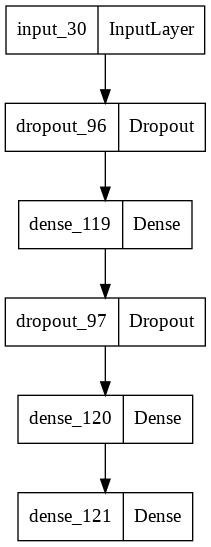

In [ ]:
plot_model(create_model())

# Training

In [ ]:
architecture_name = "mfcc_mlpV1_smoothing0.2_try1"
createFolder(folder_path + "architecture/" + architecture_name)

In [ ]:
# def do_fold_training(fold, train_idx, val_idx, sample_weight=None, finetuning=False, scaling=False):
#     tmp_time = time()
#     print("\n===== Fold", fold, "=====\n")
#     global val_pred, test_pred

#     wandb.init(
#         project="dacon_covid19_classification",
#         group=architecture_name,
#         name="fold_" + str(fold)
#     ); wandb.config.step = 0

#     if scaling:
#         scaler = StandardScaler()
#         train_x = scaler.fit_transform(df_full.iloc[train_idx].drop(target_var, axis=1).copy())
#         train_y = df_full.iloc[train_idx][target_var].copy()
        
#         val_x = scaler.transform(df_full.iloc[val_idx].drop(target_var, axis=1).copy())
#         val_y = df_full.iloc[val_idx][target_var].copy()
#     else:
#         train_x = df_full.iloc[train_idx].drop(target_var, axis=1).copy()
#         train_y = df_full.iloc[train_idx][target_var].copy()
        
#         val_x = df_full.iloc[val_idx].drop(target_var, axis=1).copy()
#         val_y = df_full.iloc[val_idx][target_var].copy()
    
#     output_container = {"model": None, "pred": None, "score": -np.inf}
#     optuna_direction = 'maximize'
#     optuna_trials = 1000
#     optuna_timout = int(12 * 3600 / kfolds_spliter.get_n_splits())
#     optuna_study = create_study(direction=optuna_direction, sampler=TPESampler())
    
#     best_ntrees = [0]
#     optuna_study.optimize(
#         lambda trial: optuna_objective_function(
#             trial, fold, train_x, train_y, None, val_x, val_y, None, categoIdx=None, model_name="CAT_ORD", output_container=output_container,
#             ntrees=ntrees, eta=eta, best_ntrees=best_ntrees
#         ),
#         n_jobs=1, n_trials=optuna_trials, timeout=optuna_timout
#     )
    
#     model_list.append(output_container["model"])
#     params_list.append(optuna_study.best_params)
#     if best_ntrees[0] is not None:
#         params_list[-1]["ntrees"] = best_ntrees[0]
#     print("fold", fold, "best params :", params_list[-1])
#     val_pred[val_idx] = output_container["pred"]
#     fold_metric.append(output_container["score"])
#     print("fold", fold, "score :", fold_metric[-1])

#     if scaling:
#         test_x = scaler.transform(df_test.copy())
#     else:
#         test_x = df_test.copy()
#     test_pred += model_list[-1].predict_proba(test_x) / n_folds

#     wandb.log({"fold": fold,
#                "logloss": metrics.log_loss(val_y.tolist(), val_pred[val_idx, 1]),
#                "auc": metrics.roc_auc_score(val_y.tolist(), val_pred[val_idx, 1]),
#                "f1_score": fold_metric[-1]})
#     wandb.log(params_list[-1])
#     wandb.finish()
 
#     print("fold", fold, "time to training :", round(time() - tmp_time, 3))

In [ ]:
def do_fold_training(fold, train_idx, val_idx, sample_weight=None, finetuning=False, scaling=False):
    tmp_time = time()
    print("\n===== Fold", fold, "=====\n")
    global val_pred, test_pred

    cb_tensorboard = tf_callbacks.TensorBoard(log_dir=tb_filepath, histogram_freq=1)
    try:
        wandb.tensorboard.patch(root_logdir=tb_filepath)
    except:
        pass
    wandb.init(
        project="dacon_covid19_classification",
        group=architecture_name,
        name="fold_" + str(fold)
    ); wandb.config.step = 0


    if scaling:
        scaler = StandardScaler()
        train_x = df_full.iloc[train_idx].drop(target_var, axis=1).copy()
        train_x[num_vars + audio_vars] = scaler.fit_transform(train_x[num_vars + audio_vars])
        train_y = df_full.iloc[train_idx][target_var].copy()
        
        val_x = df_full.iloc[val_idx].drop(target_var, axis=1).copy()
        val_x[num_vars + audio_vars] = scaler.transform(val_x[num_vars + audio_vars])
        val_y = df_full.iloc[val_idx][target_var].copy()
    else:
        train_x = df_full.iloc[train_idx].drop(target_var, axis=1).copy()
        train_y = df_full.iloc[train_idx][target_var].copy()
        
        val_x = df_full.iloc[val_idx].drop(target_var, axis=1).copy()
        val_y = df_full.iloc[val_idx][target_var].copy()

    train_ds = create_dataset(train_x, train_y, sample_weight=sample_weight, batch_size=batch_size, shuffle=True)
    val_ds = create_dataset(val_x, val_y, sample_weight=None, batch_size=batch_size, shuffle=False)
    
    total_iter = int(np.ceil(df_full.shape[0] / batch_size) * epochs)
    SCHEDULE_BOUNDARIES = [int(total_iter*0.2), int(total_iter*0.4), int(total_iter*0.6), int(total_iter*0.8)]
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=SCHEDULE_BOUNDARIES,
        values=[5e-4, 1e-4, 5e-5, 1e-5, 5e-6],
    )

    cb_earlyStopping = tf_callbacks.EarlyStopping(
        patience=patient_epochs, monitor='val_auc', mode='max'
    )
    cb_modelsave = tf_callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, monitor='val_auc', mode='max', save_weights_only=True, save_best_only=True
    )

    model = create_model()
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.BinaryFocalCrossentropy(),
        # optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
        # optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        optimizer=tfa.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=weight_decay),
        metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.AUC(name="auc")]
    )
    
    print("start training")
    model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
        callbacks=[cb_modelsave, cb_earlyStopping, cb_tensorboard, TqdmCallback(verbose=1)])
    print("end training")

    model.load_weights(checkpoint_filepath)
    model.trainable = False

    model_list.append(model)
    val_pred[val_idx] = model_list[-1].predict(val_ds)
    fold_metric.append(metrics.f1_score(val_y.tolist(), [1 if i > threshold else 0 for i in val_pred[val_idx, 1]]))
    print("fold", fold, "score :", fold_metric[-1])

    if scaling:
        test_x = df_test.copy()
        test_x[num_vars + audio_vars] = scaler.transform(test_x[num_vars + audio_vars])
    else:
        test_x = df_test.copy()
    test_pred += model_list[-1].predict(test_x) / n_folds

    wandb.log({"fold": fold,
               "logloss": metrics.log_loss(val_y.tolist(), val_pred[val_idx, 1]),
               "auc": metrics.roc_auc_score(val_y.tolist(), val_pred[val_idx, 1]),
               "f1_score": fold_metric[-1]})
    wandb.finish()
 
    print("fold", fold, "time to training :", round(time() - tmp_time, 3))

In [ ]:
# # learning parameter setting
# ntrees = 5000
# eta = None

# learning parameter setting
epochs = 30
patient_epochs = 10
batch_size = 4

eta = 1e-3 # fixed lr is replaced by lr scheduler 
weight_decay = 1e-4

checkpoint_filepath = './tmp_checkpoint/'
tb_filepath = "./tmp_tb/"

threshold = round(df_full[target_var].mean(), 5)

In [ ]:
sample_weight = (1 / df_full.groupby(target_var).transform("count").iloc[:,0]).values

In [ ]:
model_list = []
params_list = []
fold_metric = []

val_pred = np.zeros(shape=(df_full.shape[0], 2))
test_pred = np.zeros(shape=(df_test.shape[0], 2))
seed_everything()

n_folds = 5
kfolds_spliter = StratifiedKFold(n_folds, shuffle=True, random_state=42)

start_time_training = time()
# fold training
for fold, (train_idx, val_idx) in enumerate(kfolds_spliter.split(df_full, y=df_full[target_var])):
    start_mem = memory_usage()   
    do_fold_training(fold, train_idx, val_idx, sample_weight[train_idx], finetuning=False, scaling=True)
    gc.collect()
    end_mem = memory_usage()
    print("@Memory leaked :", end_mem - start_mem, "\n")
end_time_training = time()

[debug] memory usage:   2214.582 MB

===== Fold 0 =====



global_step,▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇██
train/epoch_accuracy,▁▆▅▇▅▅▆██▇▇▇
train/epoch_auc,▁▃▂▇▄▄▇██▇▇▇
train/epoch_learning_rate,██████▁▁▁▁▁▁
train/epoch_loss,█▅▄▂▃▃▂▁▁▁▂▂
train/global_step,▁▁▂▂▃▄▄▅▅▆▆▇▇█
validation/epoch_accuracy,▁▄▆▄█▅█▇▇▇▇▅
validation/epoch_auc,▃▁▄▄▆▆▆▇████
validation/epoch_loss,█▅▂▃▁▄▁▁▁▂▂▂
validation/evaluation_accuracy_vs_iterations,▁▄▆▄█▅█▇▇▇▇▅
validation/evaluation_auc_vs_iterations,▃▁▄▄▆▆▆▇████


start training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

end training
fold 0 score : 0.1447852760736196


auc,▁
f1_score,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
logloss,▁
train/epoch_accuracy,▁▂▃▄▃▂▃▃▄▄▅▅▅▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇██
train/epoch_auc,▁▃▂▅▄▅▇▆▅▅▆▆▆▇▇▇██▇▇▅██▇▇▇█▆▆▆
train/epoch_learning_rate,███████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/epoch_loss,█▄▃▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
validation/epoch_accuracy,▁▅▆▆▇▇▇▆▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇███


fold 0 time to training : 139.31
[debug] memory usage:   2221.898 MB
@Memory leaked : 7.31640625 

[debug] memory usage:   2221.898 MB

===== Fold 1 =====



start training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

end training
fold 1 score : 0.1447852760736196


auc,▁
f1_score,▁
fold,▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
logloss,▁
train/epoch_accuracy,▃▂▁▁▁▃▄▄▄▄▄▄▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇███
train/epoch_auc,▁▂▂▃▄▅▄▅▆▆▅▆▆▆▇▇█▇▇▇▇▇▇▆▇▇▇▇▇▆
train/epoch_learning_rate,███████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/epoch_loss,█▃▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation/epoch_accuracy,▂▅▁▂▃▅▃▃▄▄▃▃▂▂▂▂▂▂▂▃▃▃▃▄▄▅▆▇▇█


fold 1 time to training : 128.201
[debug] memory usage:   2227.891 MB
@Memory leaked : 5.9921875 

[debug] memory usage:   2227.891 MB

===== Fold 2 =====



start training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

end training
fold 2 score : 0.14705882352941177


auc,▁
f1_score,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
logloss,▁
train/epoch_accuracy,█▃▂▁▁▂▄▃▃▄▃▄▄▄▄▄▄▄▅▆▆▆▆▆▆▆▆▆▅▅
train/epoch_auc,▁▁▁▂▃▃▅▅▆▅▄▆▇▅▆▇▇▇▅▆█▅▇▆▇▅▆▆▆▄
train/epoch_learning_rate,███████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/epoch_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
validation/epoch_accuracy,▆▃▁▁▂▅▇▅▆▅▆▆▇▇▆▇▇▇████████████


fold 2 time to training : 129.963
[debug] memory usage:   2235.270 MB
@Memory leaked : 7.37890625 

[debug] memory usage:   2235.270 MB

===== Fold 3 =====



start training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

end training
fold 3 score : 0.14705882352941177


auc,▁
f1_score,▁
fold,▁
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
logloss,▁
train/epoch_accuracy,▁▃▃▄▄▄▅▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
train/epoch_auc,▁▃▄▄▅▅▅▆▆▇▅▆▆▇▆▆█▇▇██▇█▆▇▆▇▇▆▆
train/epoch_learning_rate,███████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/epoch_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
validation/epoch_accuracy,▁▄▄▆▅▅▄▄▄▅▅▅▅▅▅▆▆▆▆▅▅▅▄▅▆▇▇███


fold 3 time to training : 127.155
[debug] memory usage:   2247.539 MB
@Memory leaked : 12.26953125 

[debug] memory usage:   2247.539 MB

===== Fold 4 =====



start training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

end training
fold 4 score : 0.14496314496314497


auc,▁
f1_score,▁
fold,▁
global_step,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
logloss,▁
train/epoch_accuracy,█▃▃▁▃▄▄▅█▇█▇██▇█
train/epoch_auc,▂▁▄▃▅▅▅▅▆▆█▅▆▇▅▆
train/epoch_learning_rate,███████▂▂▂▂▂▂▂▂▁
train/epoch_loss,█▅▂▃▁▂▂▁▁▁▁▂▁▁▂▂
train/global_step,▁▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
validation/epoch_accuracy,▆▂▁▂▅▆▅▇█▇███▇▇▇


fold 4 time to training : 75.471
[debug] memory usage:   2257.961 MB
@Memory leaked : 10.421875 



In [ ]:
avg_score = 0
for idx, value in enumerate(fold_metric):
    print("fold", idx, "score :", value)
    avg_score += value / n_folds
print("average score :", avg_score)

fold 0 score : 0.1447852760736196
fold 1 score : 0.1447852760736196
fold 2 score : 0.14705882352941177
fold 3 score : 0.14705882352941177
fold 4 score : 0.14496314496314497
average score : 0.14573026883384155


In [ ]:
wandb.finish()
gc.collect()

103

# Submission

In [ ]:
dataframe(val_pred).to_csv(folder_path + "architecture/" + architecture_name + "/valPred_" + architecture_name + ".csv", index=False)
dataframe(test_pred).to_csv(folder_path + "architecture/" + architecture_name + "/testPred_" + architecture_name + ".csv", index=False)

In [ ]:
submission = pd.read_csv(folder_path + 'open.zip (Unzipped Files)/sample_submission.csv')
submission['covid19'] = [1 if i > threshold else 0 for i in test_pred[:,1]]
submission.to_csv(folder_path + "architecture/" + architecture_name + "/submission_" + architecture_name + ".csv", index=False)